---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>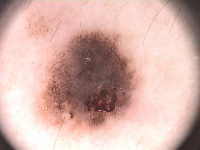</td><td>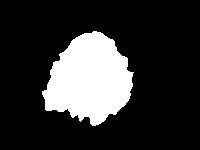</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk('/kaggle/input/ph2dataset/PH2Dataset/PH2_Dataset/'):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [4]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

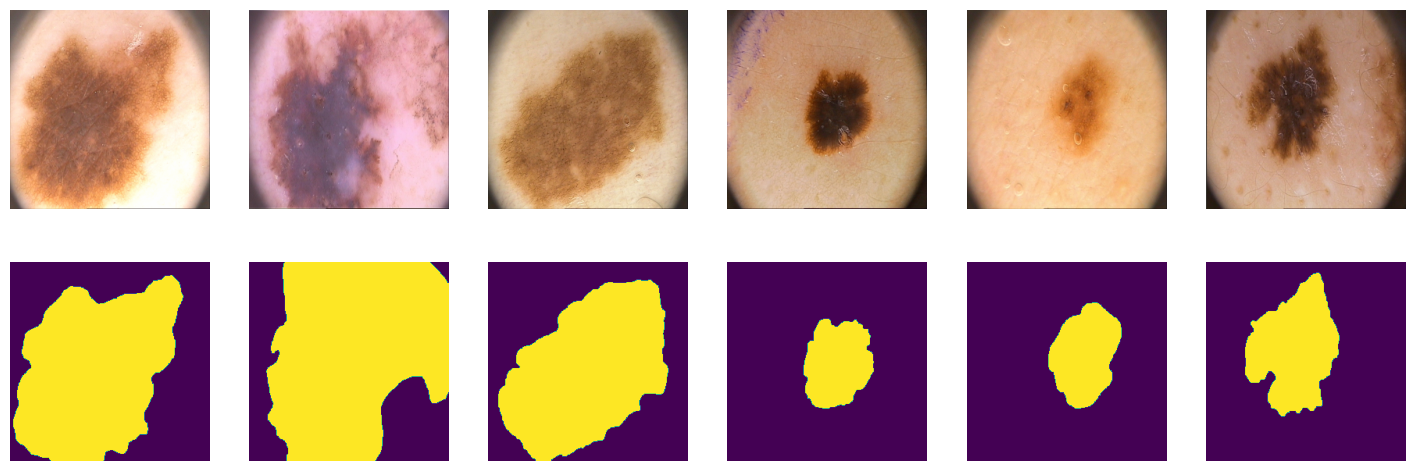

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

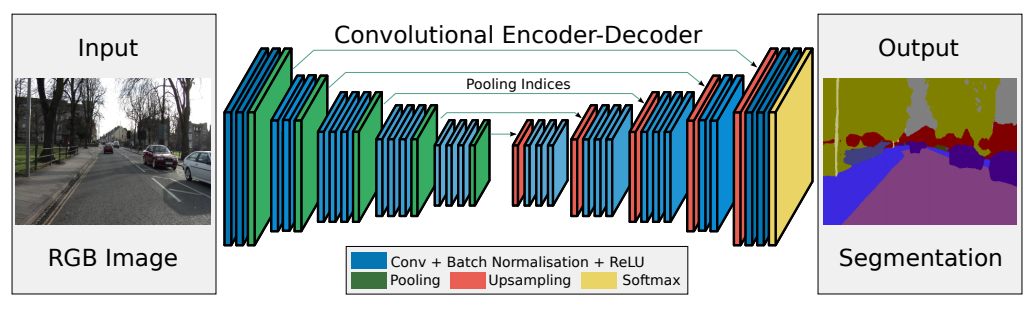

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import gc

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 0
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.pool0 = nn.MaxPool2d(kernel_size=2,
                                  stride=2,
                                  return_indices=True)  # 256 -> 128

        # encoder 1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )

        self.pool1 = nn.MaxPool2d(kernel_size=2,
                                  stride=2,
                                  return_indices=True)  # 128 -> 64

        # encoder 2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.pool2 = nn.MaxPool2d(kernel_size=2,
                                  stride=2,
                                  return_indices=True)  # 64 -> 32

        # encoder 3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool3 = nn.MaxPool2d(kernel_size=2,
                                  stride=2,
                                  return_indices=True)  # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024,
                      out_channels=512,
                      kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        # 16 * 16

        # decoder (upsampling)

        # decoder 0
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                               out_channels=256,
                               kernel_size=3,
                               padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # decoder 1
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                               out_channels=128,
                               kernel_size=3,
                               padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # decoder 2
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                               out_channels=64,
                               kernel_size=3,
                               padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # decoder 3
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                               out_channels=1,
                               kernel_size=3,
                               padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, ind_0 = self.pool0(self.enc_conv0(x))
        e1, ind_1 = self.pool1(self.enc_conv1(e0))
        e2, ind_2 = self.pool2(self.enc_conv2(e1))
        e3, ind_3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind_3))
        d1 = self.dec_conv1(self.upsample0(d0, ind_2))
        d2 = self.dec_conv2(self.upsample0(d1, ind_1))
        d3 = self.dec_conv3(self.upsample0(d2, ind_0))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [12]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.sigmoid(outputs) 
    outputs = torch.where(outputs > 0.5, 1, 0)
    
    
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W

    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zzero if both are 0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if Truth=0 or Prediction=0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [13]:
def bce_loss(y_pred, y_real):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = (1 - y_real) * y_pred + torch.log(1 + torch.exp(-y_pred))
    return torch.mean(loss)

In [14]:
best_model = {'model': None, 
              'val_score': None}

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [15]:
def train(model, 
          opt, 
          loss_fn, 
          epochs, 
          data_tr, 
          data_val, 
          metric=iou_pytorch):
    
    torch.cuda.empty_cache()
    gc.collect()
    
    X_val, Y_val = next(iter(data_val))
    
    losses = {'train_loss': [], 
              'val_loss': []}
    
    scores = {'train_score': [], 
              'val_score': []}
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch) # forward-pass
            
            loss.backward() # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        losses['train_loss'].append(avg_loss.item())
       
        
        # show intermediate results on validation data
        model.eval()      # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu()   # detach and put into cpu
            loss = loss_fn(Y_hat, Y_val)                     # forward-pass
            
        losses['val_loss'].append(loss.item())
        
        scores['train_score'].append(score_model(model, iou_pytorch, data_tr))
        scores['val_score'].append(score_model(model, iou_pytorch, data_val))
        
        # update best_model
        if not best_model['model'] or best_model['score'] < scores['val_score'][-1]:
            best_model['model'] = model
            best_model['score'] = scores['val_score'][-1]
            
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
        # visualize losses
        fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
        rng = list(range(1, epoch+2))
        plt.xlim(1, epochs+1)
        plt.ylim(0, 1.0)
        
        plt.plot(rng, losses['train_loss'], label='train_loss')
        plt.plot(rng, losses['val_loss'], label='val_loss')
        
        plt.plot(rng, scores['train_score'], label='train_score')
        plt.plot(rng, scores['val_score'], label='val_score')
        
        ax.set_xticks(np.arange(1, epochs+1, 1))
        plt.xlabel('epoch')
        plt.ylabel('loss/score value')
        
        plt.grid()
        plt.legend()
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [16]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


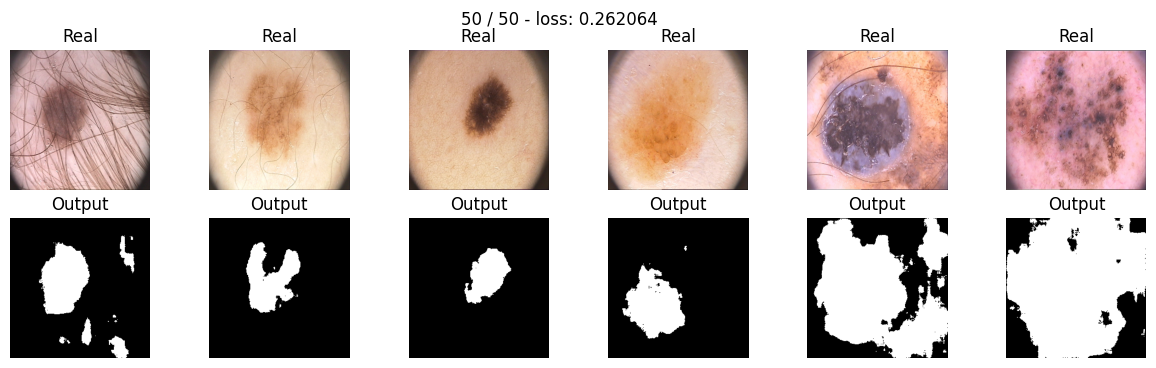

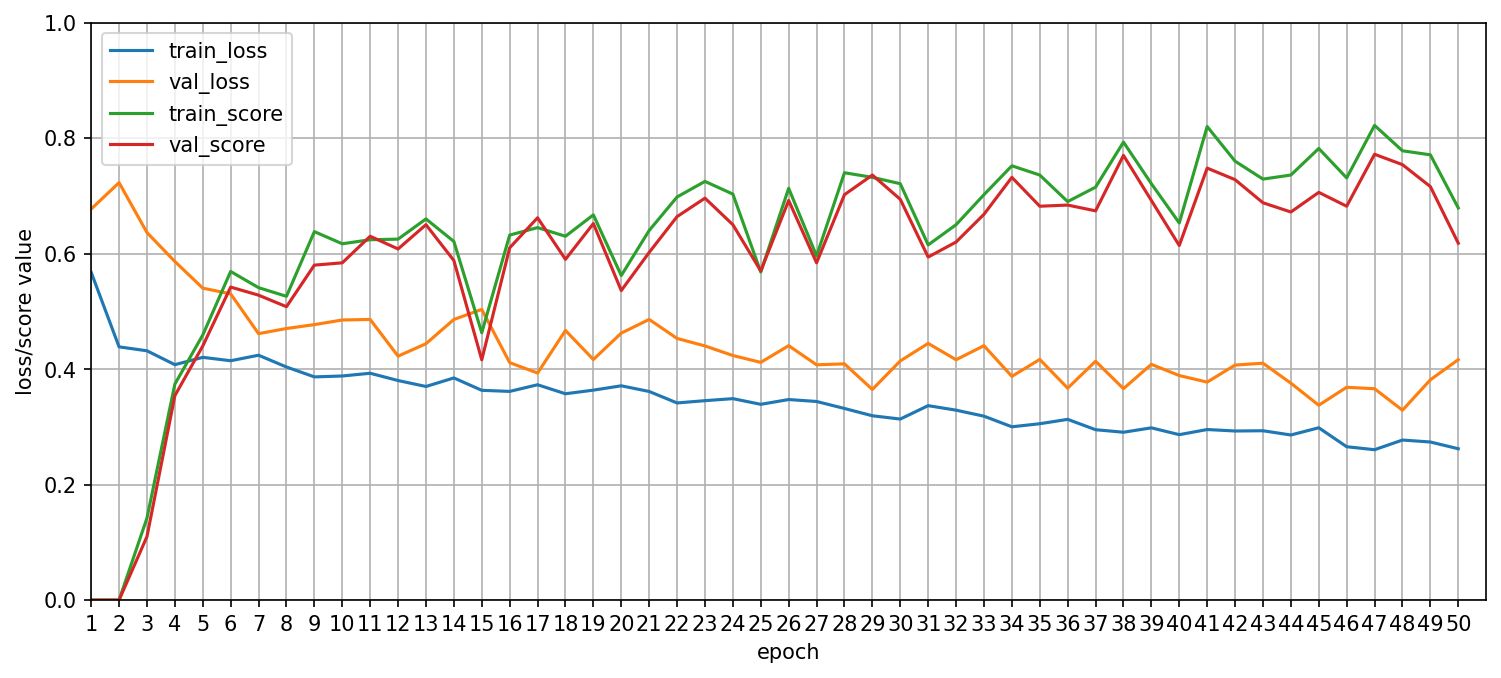

In [18]:
model = SegNet().to(device)
max_epochs = 50
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

Глядя на график score, можно увидеть, что модель не очень стабильно выдает результаты (скорее всего, это связано с маленьким размером батча, но при большем размере будет вылетать ошибка на сетяъ Unet. Визуально модель сегментирует неплохо.

In [19]:
score_model(model, iou_pytorch, data_val)

0.6180000305175781

Ответьте себе на вопрос: не переобучается ли моя модель?


НА валидационной выборке модель показала результат немного хуже. На 40 эпохах заметно небольшое переобучение. 27 эпох было достаточно, чтобы она не переобучилась.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [20]:
def dice_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)
    eps = 1.
    num = 2 * torch.sum(y_real * y_pred)
    den = torch.sum(y_real + y_pred)
    res = (num + eps) / (den + eps)
    return 1 - res

Проводим тестирование:

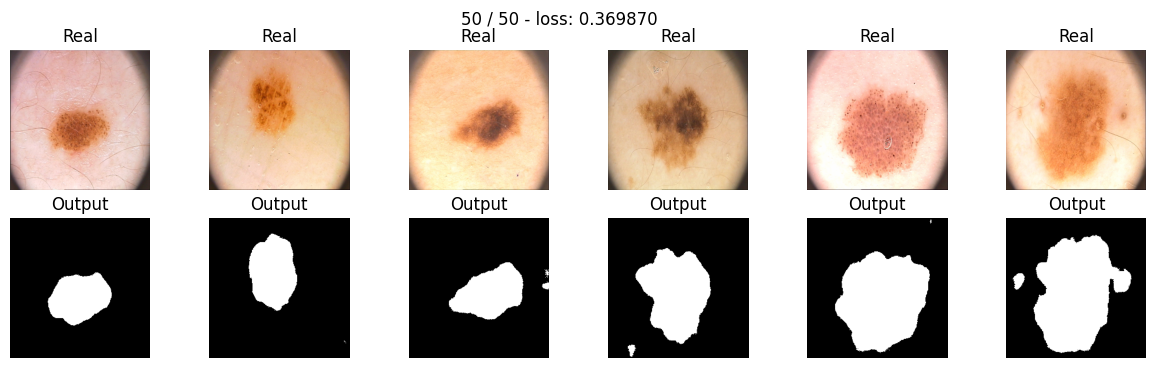

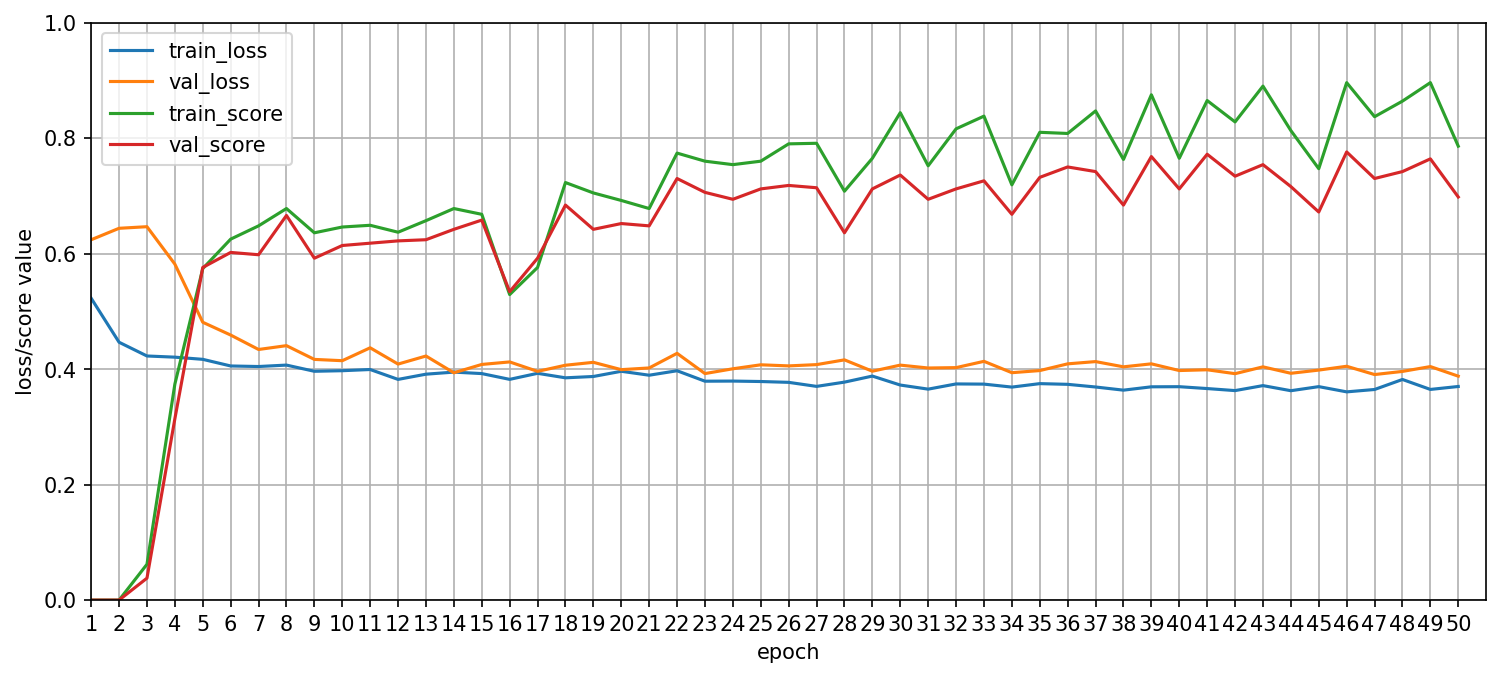

In [21]:
model_dice = SegNet().to(device)

max_epochs = 50
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [22]:
score_model(model_dice, iou_pytorch, data_val)

0.6980000019073487

На тренировочных данных качество модели с dice_loss выше, чем при прошлом лоссе, но на валидационных - результат отличается не сильно, но он более стабильный. 

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [23]:
def focal_loss(y_pred, y_real, eps = 1e-4, gamma = 2):
    y_real = torch.unsqueeze(y_real, 1) 
    y_pred = torch.unsqueeze(y_pred, 1) 
    
    y_pred = torch.clamp(torch.sigmoid(y_pred), eps, 1 - eps)

    focals = ((1 - y_pred) ** gamma) * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)
    
    return -torch.mean(focals)

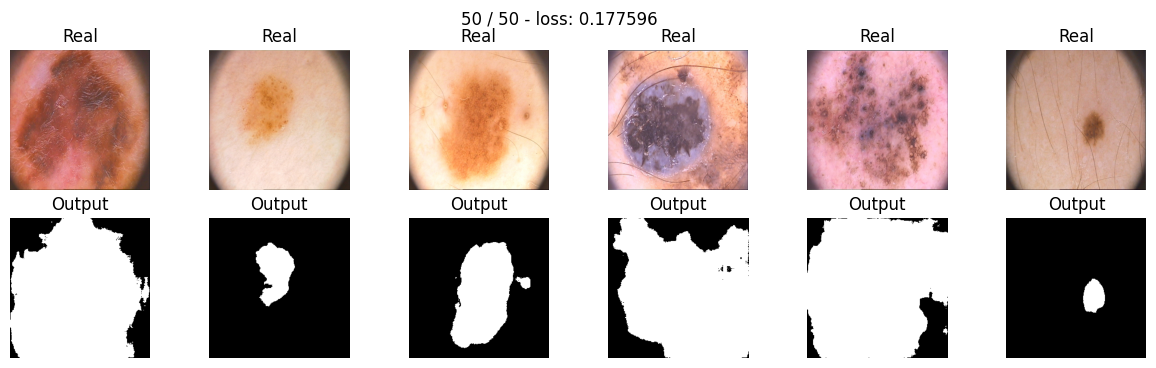

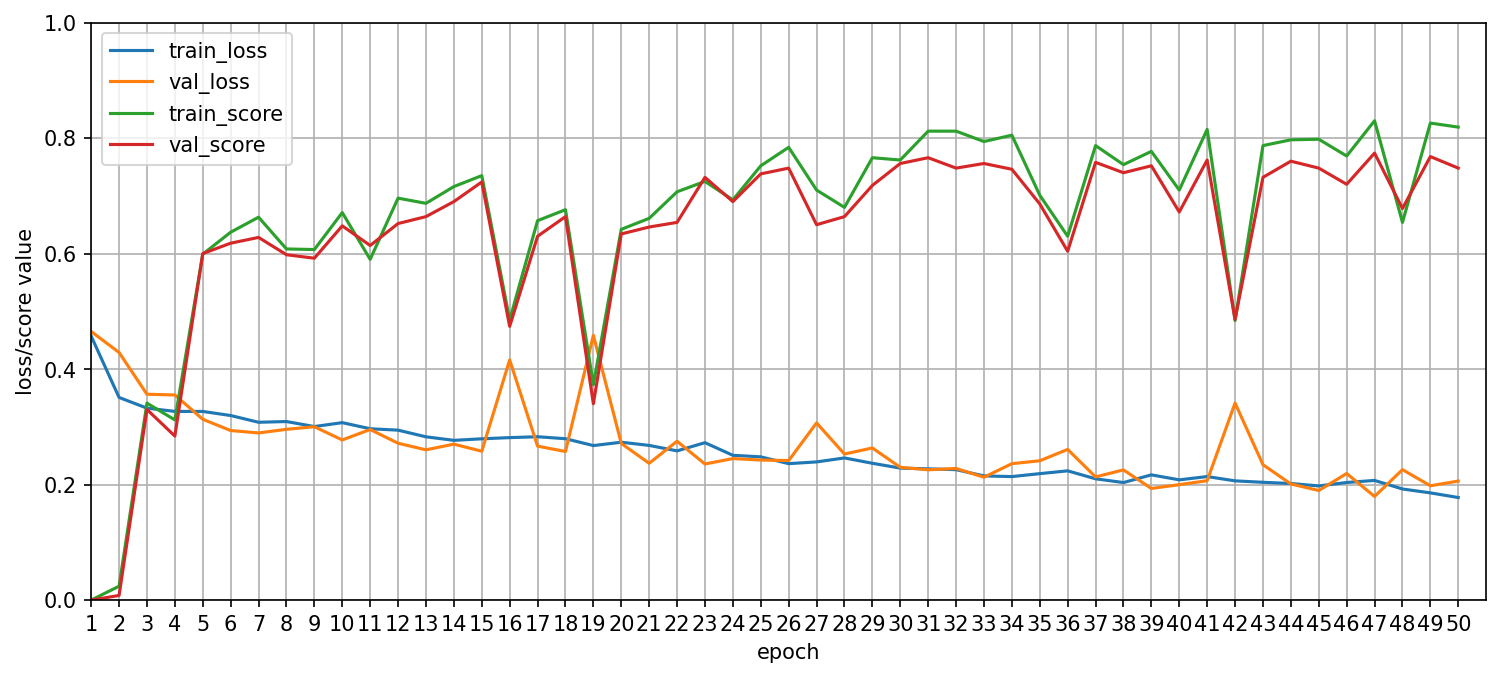

In [24]:
model_focal = SegNet().to(device)

max_epochs = 50
optimaizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [25]:
score_model(model_focal, iou_pytorch, data_val)

0.7480000138282776

В focal_loss заметны резкие спады качества, но в целом модель сегментирует тоже неплохо.

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Tversky loss

$TI = \frac{TP}{TP + \alpha * FP + \beta * FN}$

$L_{Tversky} = 1 - TI$

In [26]:
def tversky_loss(y_pred, y_real, alpha=0.15, beta=0.85): 
    eps = 1e-6
    y_pred = torch.sigmoid(torch.unsqueeze(y_pred, 1))
    y_real = torch.unsqueeze(y_real, 1) 
    TP = torch.sum(y_pred * y_real)
    FP = torch.sum(y_pred * (1 - y_real))
    FN = torch.sum((1 - y_pred) * y_real)
    
    ans = 1 - (TP + eps) / (TP + alpha*FP + beta*FN + eps)
    return ans    

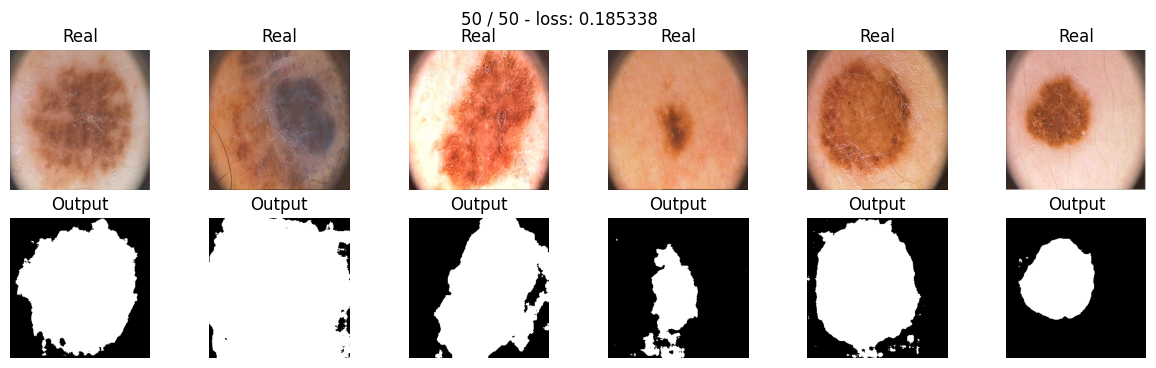

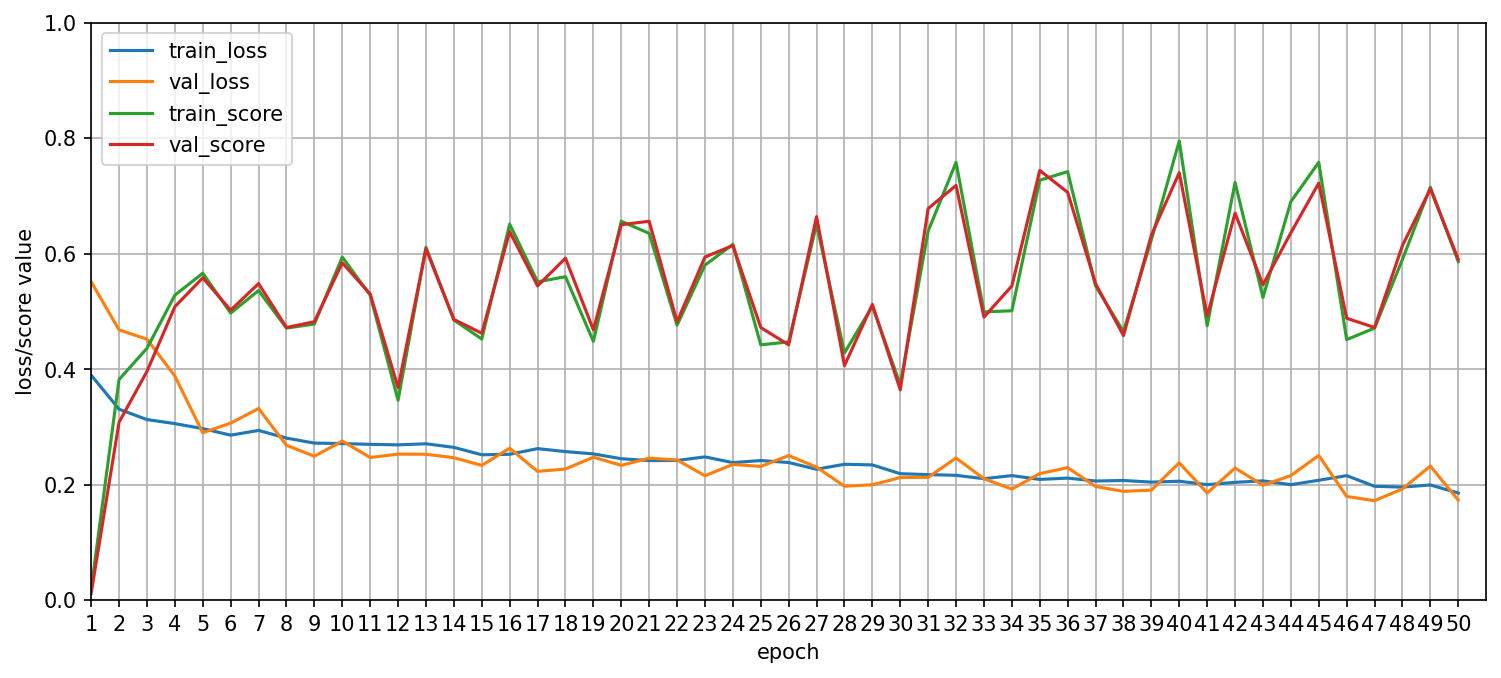

In [27]:
model_tvesky = SegNet().to(device)

max_epochs = 50
optimaizer = torch.optim.Adam(model_tvesky.parameters())
train(model_tvesky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [28]:
torch.cuda.empty_cache()
gc.collect()
score_model(model_tvesky, iou_pytorch, data_val)

0.5900000333786011

С tversky_loss видны сильные скачки. Возможно, это связано с параметром beta, который нужно подбирать, чтобы добиться лучшего результата. Максимум score примерно на том же уровне, что и у прошлых лоссов.

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

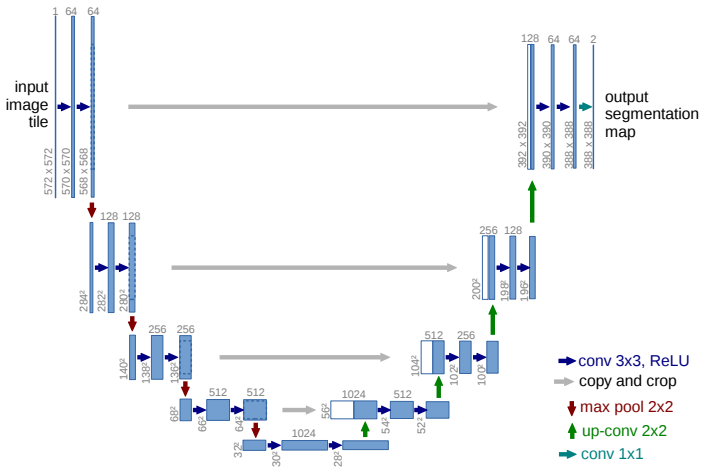

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [29]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 0
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 256 -> 128

        # encoder 1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 128 -> 64

        # encoder 2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 64 -> 32

        # encoder 3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        # decoder 0
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)       # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512 * 2, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.Conv2d(in_channels=512, out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        # decoder 1
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)        # 32 -> 64     
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256 * 2, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.Conv2d(in_channels=256, out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        # decoder 2
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)        # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128 * 2, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        # decoder 3
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64 * 2, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.Conv2d(in_channels=64, out_channels=1,kernel_size=3,padding=1),
            nn.BatchNorm2d(1))
    

    def forward(self, x):
        # encoder
        skip_0 = self.enc_conv0(x)
        e0, ind_0 = self.pool0(skip_0)
        
        skip_1 = self.enc_conv1(e0)
        e1, ind_1 = self.pool1(skip_1)
        
        skip_2 = self.enc_conv2(e1)
        e2, ind_2 = self.pool2(skip_2)
        
        skip_3 = self.enc_conv3(e2)
        e3, ind_3 = self.pool3(skip_3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        concat_0 = torch.cat([self.upsample0(b, ind_3), skip_3], 1)
        d0 = self.dec_conv0(concat_0)
        
        concat_1 = torch.cat([self.upsample1(d0, ind_2), skip_2], 1)
        d1 = self.dec_conv1(concat_1)
        
        concat_2 = torch.cat([self.upsample2(d1, ind_1), skip_1], 1)
        d2 = self.dec_conv2(concat_2)
        
        concat_3 = torch.cat([self.upsample3(d2, ind_0), skip_0], 1)
        d3 = self.dec_conv3(concat_3)
        
        return d3

In [30]:
device

device(type='cuda')

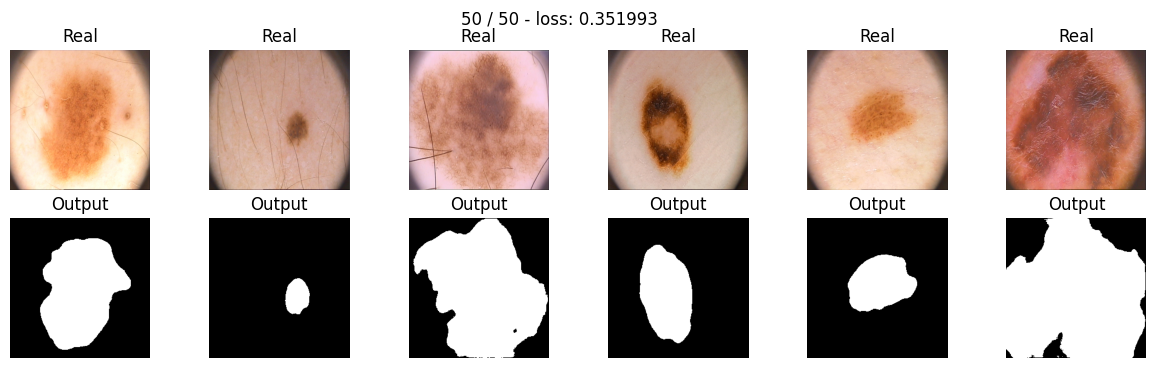

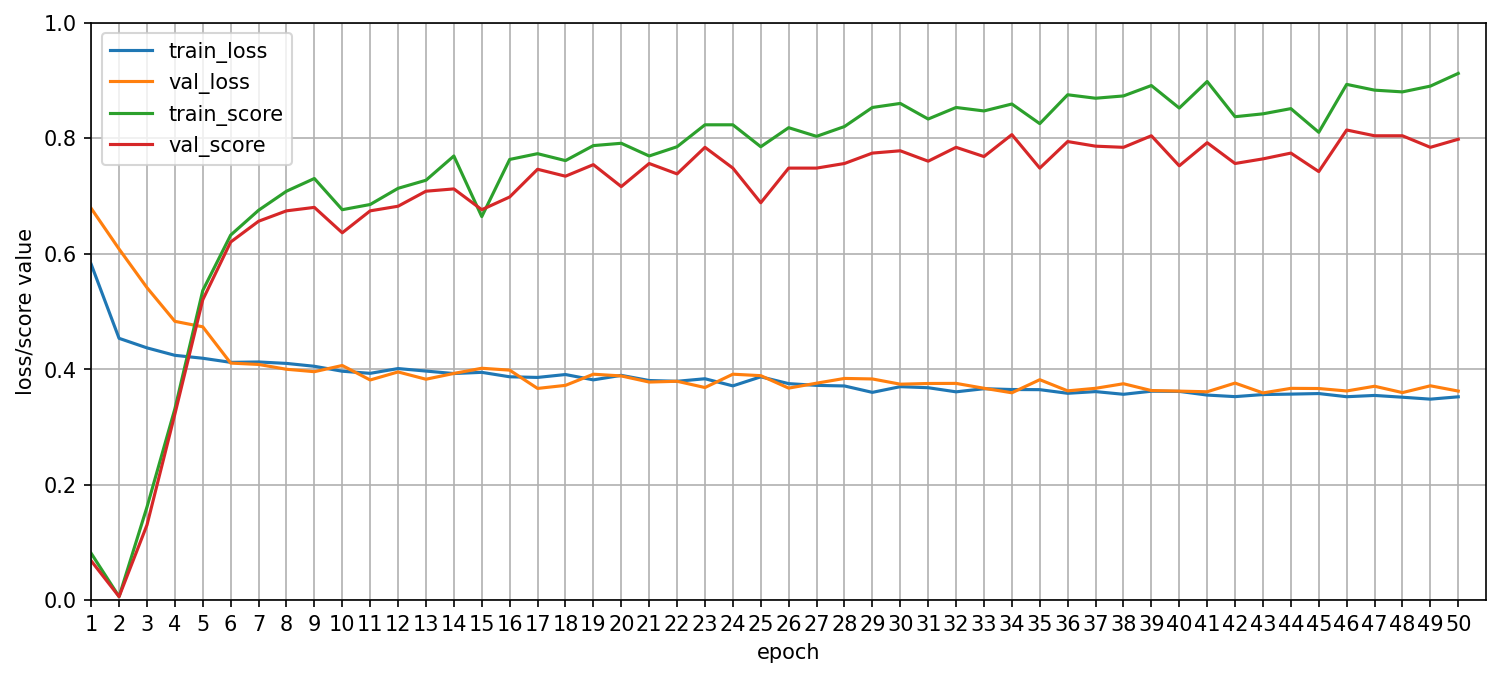

In [31]:
torch.cuda.empty_cache()
gc.collect()
unet_model = UNet().to(device)
max_epochs = 50
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [32]:
torch.cuda.empty_cache()
gc.collect()
score_model(unet_model, iou_pytorch, data_val)

0.7980000257492066

Для моделях unet будем использовать bce_loss в качестве лосса, так как не было замечено явного преимущества какого-либо другого лосса в предыдущих моделях. 

Модель unet справляется явно лучше обычного segnet, к тому же, результаты более стабильные.

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [33]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 0
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 256 -> 128

        # encoder 1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 128 -> 64

        # encoder 2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 64 -> 32

        # encoder 3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        # decoder 0
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1)       # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512 * 2, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.Conv2d(in_channels=512, out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        # decoder 1
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1)         # 32 -> 64     
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256 * 2, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.Conv2d(in_channels=256, out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        # decoder 2
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1)        # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128 * 2, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        # decoder 3
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64 * 2, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.Conv2d(in_channels=64, out_channels=1,kernel_size=3,padding=1),
            nn.BatchNorm2d(1))
    

    def forward(self, x):
        # encoder
        skip_0 = self.enc_conv0(x)
        e0, ind_0 = self.pool0(skip_0)
        
        skip_1 = self.enc_conv1(e0)
        e1, ind_1 = self.pool1(skip_1)
        
        skip_2 = self.enc_conv2(e1)
        e2, ind_2 = self.pool2(skip_2)
        
        skip_3 = self.enc_conv3(e2)
        e3, ind_3 = self.pool3(skip_3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        concat_0 = torch.cat([self.upsample0(b, output_size=skip_3.size()), skip_3], 1)
        d0 = self.dec_conv0(concat_0)
        
        concat_1 = torch.cat([self.upsample1(d0, output_size=skip_2.size()), skip_2], 1)
        d1 = self.dec_conv1(concat_1)
        
        concat_2 = torch.cat([self.upsample2(d1, output_size=skip_1.size()), skip_1], 1)
        d2 = self.dec_conv2(concat_2)
        
        concat_3 = torch.cat([self.upsample3(d2, output_size=skip_0.size()), skip_0], 1)
        d3 = self.dec_conv3(concat_3)
        
        return d3


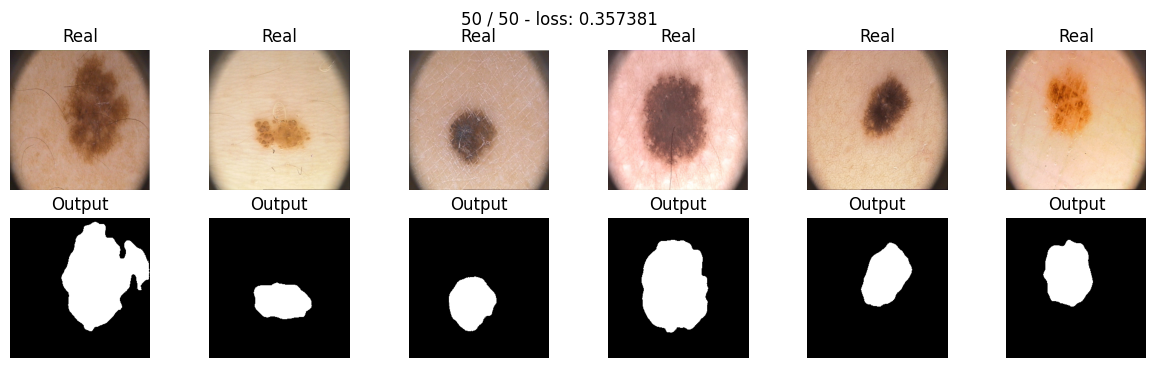

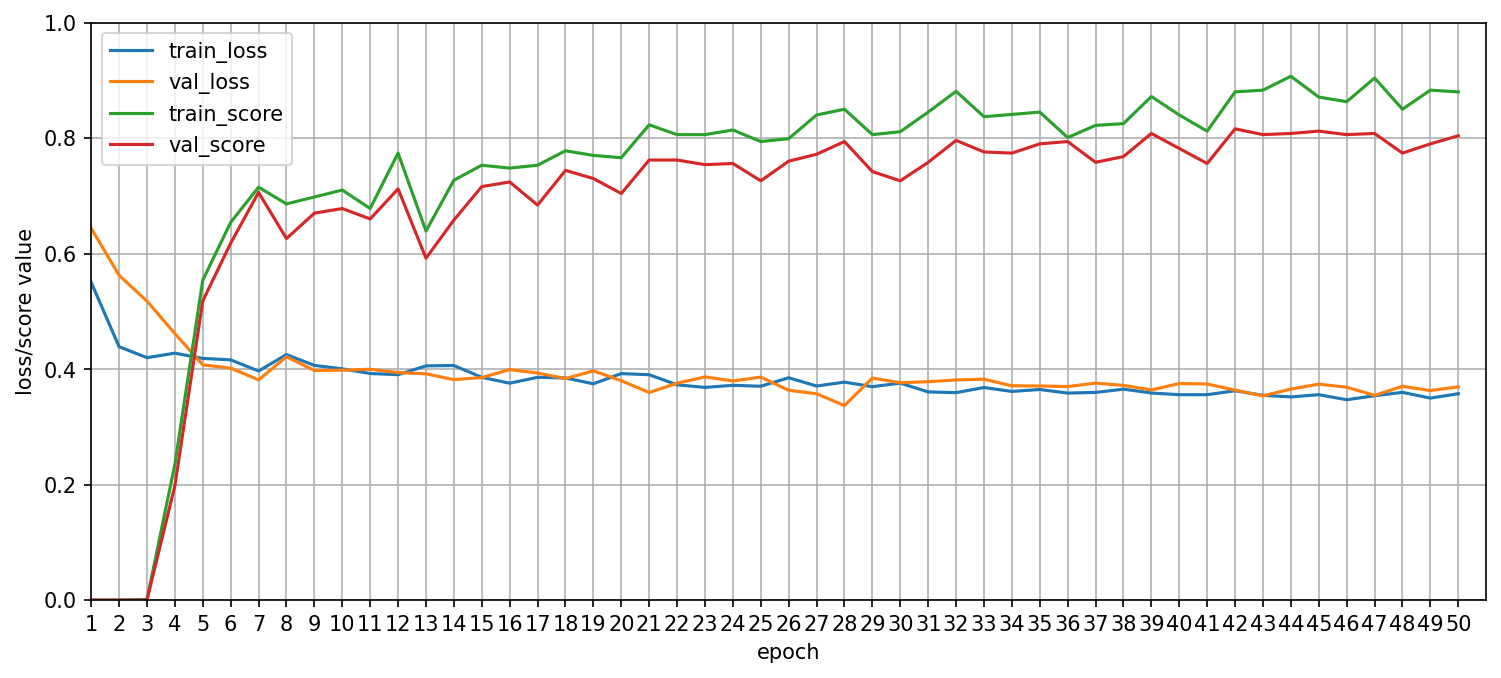

In [34]:
torch.cuda.empty_cache()
gc.collect()
unet2_model = UNet2().to(device)
max_epochs = 50
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)


In [35]:
torch.cuda.empty_cache()
gc.collect()
score_model(unet2_model, iou_pytorch, data_val)

0.8040000200271606

Результат примерно такой-же, как и у обычной U-net - тоже хороший. 

## Тестирование лучшей модели.

In [36]:
best_model

{'model': UNet2(
   (enc_conv0): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU()
   )
   (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (enc_conv1): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU()
   )
   (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (enc

score - это и есть val_score, я опечатался при update в функции train_model

In [38]:
score_model(best_model['model'], iou_pytorch, data_ts)

0.7600000262260437

Сделайте вывод, какая из моделей лучше

## Отчет

Был обработан датасет с медицинскими изуображениями. Задание состояло в том, чтобы как можно лучше отобразить рисунок опухоли в бинарном формате. Для проверки качества сегментации была использована метрика IOU - отношение пресечения предикта и правильной сегментации, к их объединению.

Для сегментации изображений были построены сети SegNet, Unet, Unet-2. 

В качестве loss функций использовались функции: bce_loss, dice_loss, focal_loss, tversky_loss. 

1. При сравнении функций потерь было выявлено, что функции потерь не так сильно влияют на качество сегментации, как параметры модели. Однако tversky_loss показала результат наиболее нестабильный относительно других функций.
В целом, SegNet показывала лучший результат в районе 0.7 - 0.75 для всех функций потерь.

2. При сравнении архитектур моделей, победила модель UNet_2 (применение transposed_2d - в качестве upsampling и conv2d вместо maxpool для downsampling) - результат 0.816 на валидационной выборке.

3. На тестовой выборке лучшая модель показала результат 0.76. 

4. Так-как не было сказано, какое качество считается приемлимым, то будем оценивать сегментацию визуально. Можно сказать, что все модели сегментировали хорошо, особенно это заметно на небольших опухолях. На мой взгляд проблемы с сегментацией появлялись тогда, когда на картинках были опухоли большого размера и со слабо выраженными границами.